In [38]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

from io import StringIO
from IPython.display import Image, display
import pydotplus

## Análisis Exploratorio

In [2]:
# Carga de los datos
data = pd.read_excel('Real estate valuation data set.xlsx')
data.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [3]:
# Información de los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


In [4]:
# Descripción de los datos
data.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [5]:
# Elimino la columna 'No'
data.drop('No', axis=1, inplace=True)

# Renombrar columnas
data.columns = ['transaction_date','house_age','distance_to_station','n_stores','latitude','longitude','price']

# Convertir tipo de datos
data['transaction_date'] = pd.to_datetime(data['transaction_date'], format='%Y/%m/%d')

In [6]:
# Observo los valores únicos en la variable 'transaction_date'
data['transaction_date'].unique()

array(['1970-01-01T00:00:00.000002012', '1970-01-01T00:00:00.000002013'],
      dtype='datetime64[ns]')

La variable 'transaction_date' sólo contiene dos elementos distintos que no tienen mayor relevancia para el análisis, por lo que, la elimino de los datos.

In [7]:
data.drop( 'transaction_date', axis=1, inplace=True)

### Visualización de datos geográficos

Contamos con datos geográficos(longitud, latitud). Los visualizamos para buscar patrones.  


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

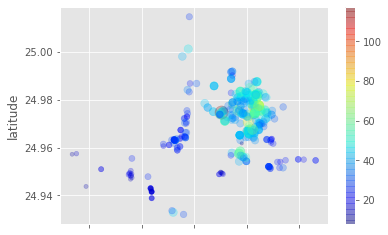

In [8]:
data.plot(kind='scatter', x='longitude', y='latitude', alpha=.25,
          s=data['price']*1.5,c=data['price'], cmap=plt.get_cmap('jet'), colorbar=True)

Podemos observar que existe un área donde se concentran una gran cantidad de viviendas con precios medios-altos, sin embargo, en esta área se puede observar que hay instancias con valores bajos. Las vivivendas de precios más bajos, se encuentran dispersas, por lo general, alejadas del área anteriormente mencionada. 

### Correlaciones

In [9]:
corr_matrix = data.corr(method='spearman')
corr_matrix['price'].sort_values()

distance_to_station   -0.775948
house_age             -0.281753
longitude              0.437672
latitude               0.578419
n_stores               0.617333
price                  1.000000
Name: price, dtype: float64

Mediante el coeficiente de correlación (de Spearman), podemos resaltar que:
* La distancia hasta la estación del metro(distance_to_station) y,
* La cantidad de tiendas de conveniencias cercanas(n_store), 

están fuertemente correlacionadas con el precio de las viviendas. Más, esto no significa causalidad.

## <b>Modelo (Bosque Aleatorio)

In [10]:
# Datos de entrada
# ================================================================
X = data
y = data.pop('price')
X.head(2)

,house_age,distance_to_station,n_stores,latitude,longitude
0,32.0,84.87882,10,24.98298,121.54024
1,19.5,306.59470,9,24.98034,121.53951


In [11]:
# Separar datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=.3)

### DecisionTreeRegressor

Algoritmo de Árbol de decisión (Regresión) con parámetros por defecto.

In [13]:
# Regresor de Bosque Aleatorio
# Entrenamiento del modelo
# =====================================================================
randomf_reg = RandomForestRegressor(random_state=0)
randomf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [14]:
importancia_predictores = pd.DataFrame(
                            {'predictor': data.columns,
                             'importancia': randomf_reg.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
1,distance_to_station,0.608068
0,house_age,0.167869
4,longitude,0.100956
3,latitude,0.100732
2,n_stores,0.022376


Nuestro modelo de bosque aleatorio como el coeficiente de correlación nos indican que "distance_to_station" es la variable que mayor información nos aporta para la regresión de nuestra variable objetivo.

### Validación Cruzada (10 k-folds)

Realizo una validación cruzada de 10 k-folds para evaluar la capacidad de predicción del modelo (con los hiperparámetros por defecto).

In [15]:
# Cross-Validation
# =====================================================================
y_preds = cross_val_score(randomf_reg, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)
rf_rmse = np.sqrt(-y_preds)
print('RMSE de los 10 k-folds:')
print(rf_rmse)
print()
rf_rmse_mean = round(np.mean(rf_rmse),2)
rf_rmse_std = round(np.std(rf_rmse),2)
print(f'RMSE promedio: {rf_rmse_mean}, desviación: {rf_rmse_std}')

RMSE de los 10 k-folds:
[ 6.06883631 15.13032459  5.60258963  7.78305387  9.54635335  5.78060085
  6.52780971  9.00321417  5.23699947  7.37638103]

RMSE promedio: 7.81, desviación: 2.8


### Ajuste del modelo

In [21]:
modelo = RandomForestRegressor(random_state=123)     
modelo.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [53]:
# Hiperparámetros - RandomForest
# ==========================================================================

# Método de selección de muestra
bootstrap = [True, False]
# Niveles máximos en cada árbol
max_depth = [None, [x for x in np.arange(10, 120, step=5)]]
# Cantidad de características a considerar para cada división
max_features = ['auto', 'sqrt']
# Cantidad mínima de muestras requeridas para un nodo hoja
min_samples_leaf = [4, 7, 9]
# Cantidad mínimas de muestras para dividir un nodo
min_samples_split = [x for x in np.arange(5, 30, step=3)]
# Cantidad de árboles
n_estimators = [x for x in np.arange(30, 500)]

params = {
    'n_estimators'      : n_estimators,
    'max_features'      : max_features,
    'max_depth'         : max_depth,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf'  : min_samples_leaf,
    'bootstrap'         : bootstrap,
}

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(estimator=modelo, 
                        param_distributions=params,
                        scoring='neg_mean_squared_error',
                        cv=10, 
                        n_jobs=-1, 
                        random_state=40)    

random_search.fit(X_train, y_train)

/home/pablo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [-69.03421637          nan          nan          nan -79.5904142
 -80.56685504 -69.06286866 -68.25590782          nan -68.55074552]
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=123),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None,
                                                      [10, 15, 20, 25, 30, 35,
                                                       40, 45, 50, 55, 60, 65,
                                                       70, 75, 80, 85, 90, 95,
                                                       100, 105, 110, 115]],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [4, 7, 9],
                                        'min_samples_split': [5, 8, 11, 14, 17,
                                                              20, 23, 26, 29],
                                        'n_estimators': [30, 31, 32, 33, 34, 35,
                                                         36, 37, 3

In [51]:
random_search.best_params_

{'n_estimators': 235,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}